In [1]:
import os
#from pyrosm import OSM
import geopandas as gpd
import pandas as pd
import uuid
import folium
from folium.features import GeoJsonPopup
import branca.colormap as cm
import json

#project specific packages
import services.network_bands as network_bands
import services.batch_csv as batch_csv
import services.census_merge as census_merge
import services.pandas_aux as pdaux

In [2]:
#set base directory for data file paths.
base_dir = os.getcwd()
# create network graph and edges.
base_road_path = f'{base_dir}\\testEnvironment\\Data\\belfast.osm.pbf'
G, nodes, edges = network_bands.load_osm_network(file_path=base_road_path, network_type='driving', graph_type='networkx')

In [3]:
#Start locations
start_locations = pd.read_csv(f'{base_dir}\\testEnvironment\\Data\\libraries_belfast_2024.csv')
print(start_locations.columns)
#Ensure data is converted to a dataframe
start_locations_gdf = network_bands.csv_to_gdf(start_locations, 'X COORDINATE', 'Y COORDINATE', 29902, 4326)

Index(['Static Library Name', 'Number', 'Street', 'Town', 'Postcode', 'Tel No',
       'X COORDINATE', 'Y COORDINATE'],
      dtype='object')


1 of 18
2 of 18
3 of 18
4 of 18
5 of 18
6 of 18
7 of 18
8 of 18
9 of 18
10 of 18
11 of 18
12 of 18
13 of 18
14 of 18
15 of 18
16 of 18
17 of 18
18 of 18
Creating network service of sizes: [1000, 2000, 3000] metres
Processing: location 1 of 18: Ardoyne Library. 
Average time for each completion is 4.34 seconds.
Total predicted time to complete all tasks is 78.1 seconds.
4.33906102180481
The process has been running for 4.34 seconds.
Creating network service of sizes: [1000, 2000, 3000] metres
Processing: location 2 of 18: Ballyhackamore Library. 
Average time for each completion is 5.2 seconds.
Total predicted time to complete all tasks is 93.51 seconds.
6.051344871520996
The process has been running for 10.39 seconds.
Creating network service of sizes: [1000, 2000, 3000] metres
Processing: location 3 of 18: Belfast Central Library. 
Average time for each completion is 6.62 seconds.
Total predicted time to complete all tasks is 119.14 seconds.
9.465495824813843
The process has been runn

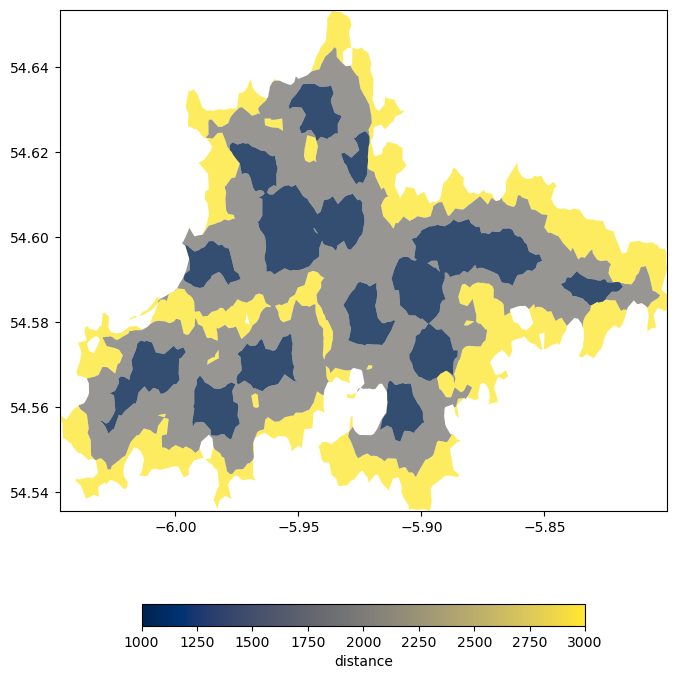

A map showing network contours has been created.


In [4]:
#Network graph creation.
#Create the network areas and service areas - Considering making this into a Class with basic GUI, but for now fine as this.
start_locations_nearest_node = network_bands.nearest_node_and_name(graph=G, start_locations=start_locations_gdf,  
                                                                   location_name = 'Static Library Name')

#Create service areas for each distance. Remember, these overlap, good for counting checking how close 
#input custom distances as a list.
search_distances = [1000,2000,3000]
#Create individual network areas around start locations. alpha area of 500 quite good for Belfast
network_areas = network_bands.network_areas(nearest_node_dict=start_locations_nearest_node, graph=G, 
                                                    search_distances=search_distances, alpha_value=500, weight = 'length', progress=True)
#Create network service areas by dissolving and differencing polygons based on distance.
network_service_areas = network_bands.network_service_areas(network_areas, dissolve_cat='distance',aggfunc='first', show_graph=True)

In [5]:
#Load in data zones from 2021 census
#Ensure evrything's in 4326 for network analysis, probably can change it back to tm65.
data_zones = gpd.read_file(f'{base_dir}\\testEnvironment\\Data\\DZ2021.shp')
data_zones.to_crs(4326, inplace=True)
#extract only belfast datazones
belfast_zones = data_zones[data_zones['LGD2014_nm'] == 'Belfast']

#Load in house data 
pointer = gpd.read_file(f'{base_dir}\\testEnvironment\\Data\\pointer_randomised.shp')
#create uuid, might be useful
pointer['uuid'] = pointer.apply(lambda i: uuid.uuid4(), axis=1)
#ensure all are in the same crs (should be 4326 or 3857)
pointer.to_crs(4326, inplace=True)
belfast_zones.to_crs(pointer.crs, inplace=True)

c:\Users\hular\anaconda3\envs\netgeo_env\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
# Perform a spatial join of pointer households and datazones in Belfast to calculate households in each datazone
joined_gdf = gpd.sjoin(pointer, belfast_zones, how='left', predicate='intersects' )
#number of points found within each datazone
datazone_pointer_count = joined_gdf.groupby('DZ2021_cd')['DZ2021_cd'].count().rename('actual_households').reset_index()
belfast_zones = pd.merge(belfast_zones, datazone_pointer_count, how = 'left')

In [7]:
#Load the Census data, file_paths in file_paths.
file_paths = [
    '/testEnvironment/Data/census_data/ni-2021-usual-residents.csv',
    '/testEnvironment/Data/census_data/ni-2021-households.csv',
    '/testEnvironment/Data/census_data/ni-2021-employment-deprivation.csv'
]
#extract each one from dataframe
loaded_csv = batch_csv.batch_csv_read(file_paths)

#check data is loaded loaded
print(loaded_csv.keys())

#force rename to maintain consistency of important join value column.
loaded_csv['ni-2021-employment-deprivation'].rename(columns={'Census 2021 Data Zone Code':'Geography code',
                                                             'Count':'employment_deprivation_count'}, inplace=True)

#OSNI data has irregular capitalisation, avoids this bug by forcing lower case. Some are 'Geography Code', 'geography Code' etc.
# Need to incorporate this properly into function
for key, df in loaded_csv.items():
    df.columns = df.columns.str.lower()
    
joined_census_data = census_merge.join_census_csv(loaded_csv, 'geography code',  drop=True,join_type='left')
#dropping some extraneous columns as they are not needed and clutter the dataset
joined_census_data.drop(columns=['household deprivation (employment) code','household deprivation (employment) label'], inplace=True)

dict_keys(['ni-2021-usual-residents', 'ni-2021-households', 'ni-2021-employment-deprivation'])
The following columns were duplicates from the right join and were dropped: [['geography', 'access census area explorer'], []]


In [8]:
# Merge the data zones with the loaded census data.
belfast_zones_census = pd.merge(belfast_zones, joined_census_data, left_on='DZ2021_cd', right_on='geography code', how='left', suffixes=('_left', '_right'))

# Drop the duplicate columns from the merged dataframe
census_merge.drop_dupe_cols(belfast_zones_census, ('_left', '_right'))

In [9]:
#Calculate CENSUS METRICS PER HOUSE in pointer data
#join the census data loaded 
#Need to force these to numeric. Ensure coerce for any nulls
belfast_zones_census['all households'] = pd.to_numeric(belfast_zones_census['all households'], errors = 'coerce')
belfast_zones_census['all usual residents'] = pd.to_numeric(belfast_zones_census['all usual residents'], errors = 'coerce')

## Calculate additional metrics. Average resident per house etc.
# actual household data has been extracted by spatial join of the randomised poitner dataset. 
#average residents per household
belfast_zones_census['avg_resi_house'] = (belfast_zones_census['all usual residents'] / belfast_zones_census['actual_households'])
#actual residents based off pointer
belfast_zones_census['actual_total_residents'] = (belfast_zones_census['avg_resi_house'] * belfast_zones_census['actual_households'])
#average number of employment deprived people per household. - Super relevant for this analysis.
belfast_zones_census['avg_emp_dep_per_house'] = (belfast_zones_census['employment_deprivation_count'] / belfast_zones_census['actual_households'])*belfast_zones_census['avg_resi_house']
#average number of employmenet deprived people per resident.
belfast_zones_census['avg_emp_dep_per_capita'] = (belfast_zones_census['employment_deprivation_count'] / belfast_zones_census['all usual residents'])*belfast_zones_census['avg_resi_house']

#Force to gdf, currently will be a panda series
belfast_zones_census = gpd.GeoDataFrame(belfast_zones_census)



In [10]:
# Spatial join to find which network contour each household falls into
households_with_contour = gpd.sjoin(pointer, network_service_areas, how="left", predicate="within")
households_with_contour = households_with_contour.drop(columns='index_right').reset_index(drop=True)

# spatial to join data zone data to each household
households_with_zones = gpd.sjoin(households_with_contour, belfast_zones_census, how="left", predicate="within").drop(columns='index_right').reset_index(drop=True)

# Group by census zone and distance and then count. Unstacks the distance columns to create separate columns for each distance.
household_counts = households_with_zones.groupby(['DZ2021_cd', 'distance']).size().unstack(fill_value=0)

#join this back to the belfast_census_zones to add the counts as new columns
belfast_zones_census = belfast_zones_census.merge(household_counts, on='DZ2021_cd', how='left')

#forces column names to string, as distance will be integer.
#belfast_census_zones.columns = belfast_census_zones.columns.astype(str)

belfast_zones_census = pdaux.append_col_prefix(belfast_zones_census, [1000, 2000,3000], prefix='households')        

#replace NaNs with 0s
pdaux.fill_na_with_zero(belfast_zones_census, ['households_1000','households_2000','households_3000'])

belfast_zones_census.head(1)

KeyError: "['households_1000'] not in index"

In [ ]:
#Create a folium map - This part's quite manual.
##ADD PIE CHARTS INSTEAD -0this is tricky
#turn this into a bunch of functions to get this smaller and more refined down the line.
#Numbers will be off due to randomisation of pointer dataset.
belfast_census_data_geojson = json.loads(belfast_zones_census.to_json())
network_service_areas_geojson = json.loads(network_service_areas.to_json())

# Create the Folium map centered around the average coordinates of your geometries, can ignore warning
map_center = belfast_zones_census.geometry.centroid.unary_union.centroid
m = folium.Map(location=[map_center.y, map_center.x], zoom_start=12)

#could turn this network_service_areas_style creation into a larger func
distances = [1000, 2000, 3000] 
colours = ['green', 'orange', 'red']
color_map = cm.LinearColormap(
    colors=colours,
    vmin=min(distances),
    vmax=max(distances),
    caption='Distance to Network Contours'
)
distance_colours = {dist: colour for dist, colour in zip(distances, colours)}
def network_service_areas_style(feature):
    """Apply styles based on the distance attribute."""
    distance = feature['properties']['distance']
    return {
        'color': distance_colours.get(distance, 'gray'),
        'weight': 2,
        'opacity': 0.8,
        'fillColor': distance_colours.get(distance, 'gray'), 
        'fillOpacity': 0.5
    }

#basic styling for the polygons
def basic_poly_styling(feature):
    return {
        'color': 'black',
        'weight':1,
        'fillOpacity': 0.1
    }

#defines the highlight colour
def highlight_function(feature):
    return {
        'color': 'yellow',
        'weight': 2,
        'fillOpacity':0.2
    }
network_service_areas_layer = folium.GeoJson(
    network_service_areas_geojson,
    style_function=network_service_areas_style,
    name = 'contours',
    tooltip=folium.GeoJsonTooltip(
        fields=['distance'],
        aliases=['Distance:'],
        localize = True
    )
)
network_service_areas_layer.add_to(m)


#census zone layer
data_zone_layer = folium.GeoJson(
    belfast_census_data_geojson,
    name='Houses within 1000m',
    style_function=basic_poly_styling,
    highlight_function=highlight_function,

    popup = GeoJsonPopup(
        fields=['DZ2021_cd', 'DZ2021_nm', 'actual_households', '1000.0', '2000.0', '3000.0'],
        aliases=['Data Zone:', 'Data Zone Name:', 'Households:', 'Households within 1km:', 
                'Households within 2km:', 'Households within 3km:'],
        localize=True,
        labels=True
    )
)
data_zone_layer.add_to(m)

# layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('test.html', cdn_resources='cdn')

m